In [1]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [2]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import json
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports successful")

✓ All imports successful


## 1. Load Gold Data

Load comments and submissions from gold tables with parent_id.

In [3]:
# Paths
gold_comments_path = workspace_root / 'data' / '01_corpus' / '02_gold' / 'reddit' / 'comments'
gold_submissions_path = workspace_root / 'data' / '01_corpus' / '02_gold' / 'reddit' / 'submissions'

print(f"Comments path: {gold_comments_path}")
print(f"Submissions path: {gold_submissions_path}")

# Check paths exist
print(f"\nPath validation:")
print(f"  Comments: {gold_comments_path.exists()}")
print(f"  Submissions: {gold_submissions_path.exists()}")

Comments path: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/02_gold/reddit/comments
Submissions path: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/02_gold/reddit/submissions

Path validation:
  Comments: True
  Submissions: True


In [4]:
# Load all comment files
print("Loading comment files...")

comment_files = list(gold_comments_path.glob('*.parquet'))
print(f"Found {len(comment_files)} comment files")

comments_list = []
for file in sorted(comment_files):
    df = read_parquet(file)
    comments_list.append(df)
    print(f"  Loaded {file.name}: {len(df):,} comments")

df_comments = pd.concat(comments_list, ignore_index=True)

print(f"\n✓ Total comments loaded: {len(df_comments):,}")
print(f"\nComment columns: {df_comments.columns.tolist()}")

Loading comment files...
Found 2 comment files
  Loaded 2016-09.parquet: 3,766,133 comments
  Loaded 2016-10.parquet: 4,932,790 comments

✓ Total comments loaded: 8,698,923

Comment columns: ['comment_id', 'submission_id', 'parent_id', 'created_utc', 'subreddit_id', 'subreddit', 'body']


In [5]:
# Load all submission files
print("Loading submission files...")

submission_files = list(gold_submissions_path.glob('*.parquet'))
print(f"Found {len(submission_files)} submission files")

submissions_list = []
for file in sorted(submission_files):
    df = read_parquet(file)
    submissions_list.append(df)
    print(f"  Loaded {file.name}: {len(df):,} submissions")

df_submissions = pd.concat(submissions_list, ignore_index=True)

print(f"\n✓ Total submissions loaded: {len(df_submissions):,}")
print(f"\nSubmission columns: {df_submissions.columns.tolist()}")

Loading submission files...
Found 2 submission files
  Loaded 2016-09.parquet: 386,214 submissions
  Loaded 2016-10.parquet: 537,217 submissions

✓ Total submissions loaded: 923,431

Submission columns: ['submission_id', 'title', 'selftext', 'created_utc', 'subreddit_id', 'subreddit', 'num_comments']


## 2. Verify parent_id Column

Check if parent_id exists and examine its structure.

In [6]:
# Check parent_id existence
print("=" * 80)
print("PARENT_ID VERIFICATION")
print("=" * 80)

print("\n1. Column Existence:")
if 'parent_id' in df_comments.columns:
    print("   ✓✓✓ parent_id column EXISTS in comments")
else:
    print("   ✗✗✗ parent_id column MISSING in comments")
    print("   CRITICAL ERROR: Cannot proceed without parent_id")
    raise ValueError("parent_id column not found in gold data")

print("\n2. Data Completeness:")
total_comments = len(df_comments)
with_parent = df_comments['parent_id'].notna().sum()
without_parent = df_comments['parent_id'].isna().sum()

print(f"   Total comments: {total_comments:,}")
print(f"   With parent_id: {with_parent:,} ({with_parent/total_comments*100:.2f}%)")
print(f"   Without parent_id: {without_parent:,} ({without_parent/total_comments*100:.2f}%)")

if without_parent > 0:
    print(f"\n   ⚠️  WARNING: {without_parent:,} comments have missing parent_id")

PARENT_ID VERIFICATION

1. Column Existence:
   ✓✓✓ parent_id column EXISTS in comments

2. Data Completeness:
   Total comments: 8,698,923
   With parent_id: 8,698,923 (100.00%)
   Without parent_id: 0 (0.00%)


In [7]:
# Examine parent_id format
print("\n3. Parent ID Format:")

# Get sample of parent_ids
sample_parents = df_comments['parent_id'].dropna().head(20)
print(f"\n   Sample parent_ids:")
for i, pid in enumerate(sample_parents, 1):
    print(f"     {i}. {pid}")

# Check format patterns
parent_ids = df_comments['parent_id'].dropna()

# Count by prefix
t1_count = (parent_ids.str.startswith('t1_')).sum()  # Comment parents
t3_count = (parent_ids.str.startswith('t3_')).sum()  # Submission parents
other_count = len(parent_ids) - t1_count - t3_count

print(f"\n   Format breakdown:")
print(f"     t1_xxxxx (comment parent): {t1_count:,} ({t1_count/len(parent_ids)*100:.2f}%)")
print(f"     t3_xxxxx (submission parent): {t3_count:,} ({t3_count/len(parent_ids)*100:.2f}%)")
print(f"     Other/Invalid format: {other_count:,} ({other_count/len(parent_ids)*100:.2f}%)")

if other_count > 0:
    print(f"\n   ⚠️  WARNING: {other_count:,} parent_ids don't match expected format")
    other_examples = parent_ids[~parent_ids.str.startswith('t1_') & ~parent_ids.str.startswith('t3_')].head(5)
    print(f"   Examples: {other_examples.tolist()}")


3. Parent ID Format:

   Sample parent_ids:
     1. t3_50kc6b
     2. t3_50kc92
     3. t3_50kcdt
     4. t3_50kcf9
     5. t3_50kcrj
     6. t3_50kcte
     7. t3_50kck4
     8. t3_50kciu
     9. t3_50kck4
     10. t3_50kd0p
     11. t3_50kcrj
     12. t3_50kd1d
     13. t3_50kd0p
     14. t3_50kcyk
     15. t1_d74qsqp
     16. t3_50kd94
     17. t3_50kdad
     18. t3_50kdad
     19. t3_50kd7n
     20. t3_50kddx

   Format breakdown:
     t1_xxxxx (comment parent): 5,967,217 (68.60%)
     t3_xxxxx (submission parent): 2,731,706 (31.40%)
     Other/Invalid format: 0 (0.00%)


## 3. Validate Parent References

Check if parent_id actually references existing comments/submissions.

In [8]:
# Create lookup sets for fast membership testing
print("Creating ID lookups...")

comment_ids = set(df_comments['comment_id'].dropna())
submission_ids = set(df_submissions['submission_id'].dropna())

print(f"✓ Comment ID set: {len(comment_ids):,} unique IDs")
print(f"✓ Submission ID set: {len(submission_ids):,} unique IDs")

Creating ID lookups...
✓ Comment ID set: 8,698,923 unique IDs
✓ Submission ID set: 923,431 unique IDs


In [23]:
# Validate parent references
print("\n" + "=" * 80)
print("PARENT REFERENCE VALIDATION")
print("=" * 80)

# Sample for detailed checking (full dataset might be slow)
SAMPLE_SIZE = 100000
if len(df_comments) > SAMPLE_SIZE:
    print(f"\nUsing sample of {SAMPLE_SIZE:,} comments for validation")
    df_sample = df_comments.sample(n=SAMPLE_SIZE, random_state=42)
else:
    print(f"\nValidating all {len(df_comments):,} comments")
    df_sample = df_comments

validation_results = {
    'total': 0,
    'top_level_valid': 0,
    'top_level_invalid': 0,
    'nested_valid': 0,
    'nested_invalid': 0,
    'missing_parent_id': 0
}

invalid_examples = []

print("\nValidating parent references...")
for idx, row in df_sample.iterrows():
    validation_results['total'] += 1
    
    parent_id = row['parent_id']
    
    if pd.isna(parent_id):
        validation_results['missing_parent_id'] += 1
        continue
    
    # Top-level comment (parent is submission)
    if parent_id.startswith('t3_'):
        # Strip t3_ prefix to match submission_id format in gold data
        submission_id_to_check = parent_id[3:]  # Remove 't3_' prefix
        if submission_id_to_check in submission_ids:
            validation_results['top_level_valid'] += 1
        else:
            validation_results['top_level_invalid'] += 1
            if len(invalid_examples) < 10:
                invalid_examples.append({
                    'type': 'top_level',
                    'comment_id': row['comment_id'],
                    'parent_id': parent_id,
                    'submission_id': row.get('submission_id', 'N/A')
                })
    
    # Nested comment (parent is another comment)
    elif parent_id.startswith('t1_'):
        # Strip t1_ prefix to match comment_id format in gold data
        comment_id_to_check = parent_id[3:]  # Remove 't1_' prefix
        if comment_id_to_check in comment_ids:
            validation_results['nested_valid'] += 1
        else:
            validation_results['nested_invalid'] += 1
            if len(invalid_examples) < 10:
                invalid_examples.append({
                    'type': 'nested',
                    'comment_id': row['comment_id'],
                    'parent_id': parent_id,
                    'submission_id': row.get('submission_id', 'N/A')
                })

# Print results
print("\n" + "=" * 80)
print("VALIDATION RESULTS")
print("=" * 80)

print(f"\nTotal comments validated: {validation_results['total']:,}")
print(f"Missing parent_id: {validation_results['missing_parent_id']:,}")

print(f"\nTop-level comments (parent = submission):")
total_top = validation_results['top_level_valid'] + validation_results['top_level_invalid']
if total_top > 0:
    print(f"  Valid references: {validation_results['top_level_valid']:,} ({validation_results['top_level_valid']/total_top*100:.2f}%)")
    print(f"  Invalid references: {validation_results['top_level_invalid']:,} ({validation_results['top_level_invalid']/total_top*100:.2f}%)")

print(f"\nNested comments (parent = comment):")
total_nested = validation_results['nested_valid'] + validation_results['nested_invalid']
if total_nested > 0:
    print(f"  Valid references: {validation_results['nested_valid']:,} ({validation_results['nested_valid']/total_nested*100:.2f}%)")
    print(f"  Invalid references: {validation_results['nested_invalid']:,} ({validation_results['nested_invalid']/total_nested*100:.2f}%)")

print(f"\nOverall validity:")
total_with_parent = validation_results['total'] - validation_results['missing_parent_id']
total_valid = validation_results['top_level_valid'] + validation_results['nested_valid']
if total_with_parent > 0:
    print(f"  {total_valid:,} / {total_with_parent:,} ({total_valid/total_with_parent*100:.2f}%) parent references are valid")

# Show invalid examples
if invalid_examples:
    print(f"\n⚠️  Found {len(invalid_examples)} invalid reference examples:")
    for i, ex in enumerate(invalid_examples[:5], 1):

        print(f"\n  Example {i} ({ex['type']}):")        
        print(f"    Submission ID: {ex['submission_id']}")

        print(f"    Comment ID: {ex['comment_id']}")       
        print(f"    Parent ID: {ex['parent_id']} (NOT FOUND)")


PARENT REFERENCE VALIDATION

Using sample of 100,000 comments for validation

Validating parent references...

VALIDATION RESULTS

Total comments validated: 100,000
Missing parent_id: 0

Top-level comments (parent = submission):
  Valid references: 31,448 (100.00%)
  Invalid references: 0 (0.00%)

Nested comments (parent = comment):
  Valid references: 64,510 (94.10%)
  Invalid references: 4,042 (5.90%)

Overall validity:
  95,958 / 100,000 (95.96%) parent references are valid

⚠️  Found 10 invalid reference examples:

  Example 1 (nested):
    Submission ID: 56pb52
    Comment ID: d8la4ur
    Parent ID: t1_d8la1ls (NOT FOUND)

  Example 2 (nested):
    Submission ID: 5667aq
    Comment ID: d8igway
    Parent ID: t1_d8ib92e (NOT FOUND)

  Example 3 (nested):
    Submission ID: 51rju6
    Comment ID: d7hki3d
    Parent ID: t1_d7ea56w (NOT FOUND)

  Example 4 (nested):
    Submission ID: 53szol
    Comment ID: d7y1ylp
    Parent ID: t1_d7wq2pz (NOT FOUND)

  Example 5 (nested):
    Subm

## 4. Thread Structure Analysis

Analyze the depth and structure of conversation threads.

In [24]:
# Analyze thread structure
print("=" * 80)
print("THREAD STRUCTURE ANALYSIS")
print("=" * 80)

# Categorize comments by thread level
df_comments['thread_level'] = 'unknown'

# Top-level: parent is submission (t3_)
top_level_mask = df_comments['parent_id'].str.startswith('t3_', na=False)
df_comments.loc[top_level_mask, 'thread_level'] = 'top_level'

# Nested: parent is comment (t1_)
nested_mask = df_comments['parent_id'].str.startswith('t1_', na=False)
df_comments.loc[nested_mask, 'thread_level'] = 'nested'

# Missing parent_id
missing_mask = df_comments['parent_id'].isna()
df_comments.loc[missing_mask, 'thread_level'] = 'missing_parent'

print("\n1. Thread Level Distribution:")
thread_counts = df_comments['thread_level'].value_counts()
for level, count in thread_counts.items():
    pct = count / len(df_comments) * 100
    print(f"   {level}: {count:,} ({pct:.2f}%)")

# Calculate approximate thread depth for nested comments
print("\n2. Estimated Thread Depth:")
print("   Note: Calculating exact depth requires recursive lookup")
print("   Top-level comments: depth = 1")
print("   Nested comments: depth >= 2")

top_count = thread_counts.get('top_level', 0)
nested_count = thread_counts.get('nested', 0)
print(f"\n   Depth 1 (top-level): {top_count:,}")
print(f"   Depth 2+ (nested): {nested_count:,}")
print(f"   Average depth estimate: {1 + (nested_count / len(df_comments)):.2f}")

THREAD STRUCTURE ANALYSIS

1. Thread Level Distribution:
   nested: 5,967,217 (68.60%)
   top_level: 2,731,706 (31.40%)

2. Estimated Thread Depth:
   Note: Calculating exact depth requires recursive lookup
   Top-level comments: depth = 1
   Nested comments: depth >= 2

   Depth 1 (top-level): 2,731,706
   Depth 2+ (nested): 5,967,217
   Average depth estimate: 1.69


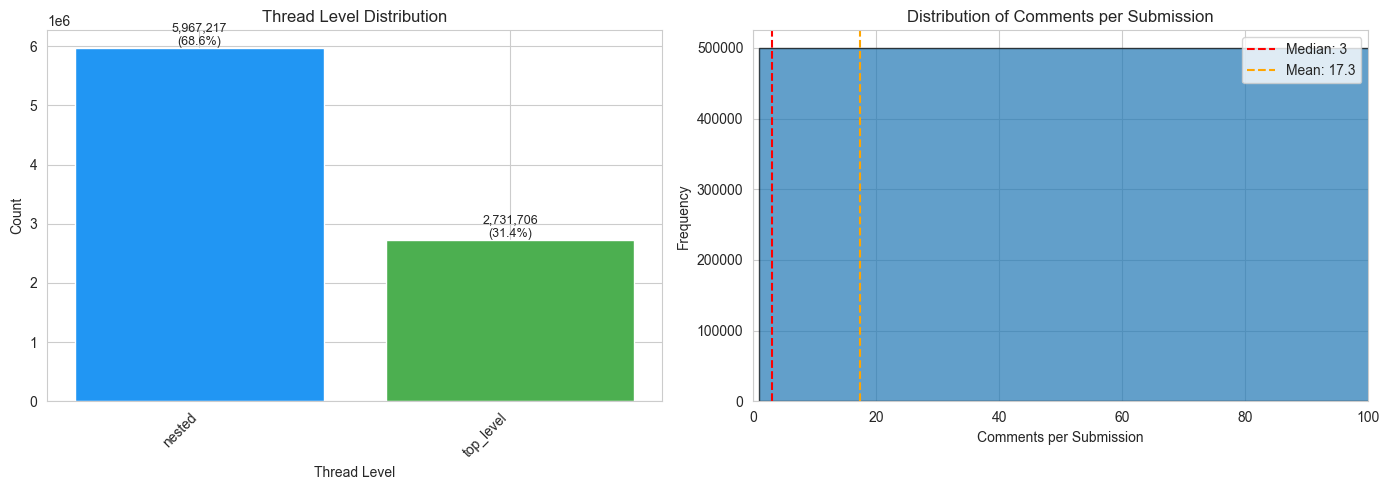


Comments per submission statistics:
  Mean: 17.33
  Median: 3
  Min: 1
  Max: 24157
  Total submissions: 501,969


In [25]:
# Visualize thread structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Thread level distribution
thread_counts = df_comments['thread_level'].value_counts()
colors = {'top_level': '#4CAF50', 'nested': '#2196F3', 'missing_parent': '#FFC107', 'unknown': '#9E9E9E'}
ax1 = axes[0]
bars = ax1.bar(range(len(thread_counts)), thread_counts.values, 
               color=[colors.get(x, '#9E9E9E') for x in thread_counts.index])
ax1.set_xticks(range(len(thread_counts)))
ax1.set_xticklabels(thread_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Count')
ax1.set_title('Thread Level Distribution')
ax1.set_xlabel('Thread Level')

# Add value labels
for i, (idx, val) in enumerate(thread_counts.items()):
    ax1.text(i, val, f'{val:,}\n({val/len(df_comments)*100:.1f}%)', 
             ha='center', va='bottom', fontsize=9)

# Plot 2: Comments per submission
comments_per_sub = df_comments.groupby('submission_id').size()
ax2 = axes[1]
ax2.hist(comments_per_sub, bins=50, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Comments per Submission')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Comments per Submission')
ax2.axvline(comments_per_sub.median(), color='red', linestyle='--', 
            label=f'Median: {comments_per_sub.median():.0f}')
ax2.axvline(comments_per_sub.mean(), color='orange', linestyle='--', 
            label=f'Mean: {comments_per_sub.mean():.1f}')
ax2.legend()
ax2.set_xlim(0, min(100, comments_per_sub.quantile(0.99)))

plt.tight_layout()
plt.show()

print(f"\nComments per submission statistics:")
print(f"  Mean: {comments_per_sub.mean():.2f}")
print(f"  Median: {comments_per_sub.median():.0f}")
print(f"  Min: {comments_per_sub.min()}")
print(f"  Max: {comments_per_sub.max()}")
print(f"  Total submissions: {len(comments_per_sub):,}")

## 5. Sample Thread Reconstruction

Reconstruct a few complete conversation threads to verify threading works correctly.

In [26]:
# Function to reconstruct a thread
def reconstruct_thread(comment_id, df_comments, max_depth=10):
    """
    Trace a comment back to its root (submission) by following parent_id chain.
    Returns list of (comment_id, body_preview) tuples from root to target.
    """
    thread = []
    current_id = comment_id
    depth = 0
    
    comment_lookup = df_comments.set_index('comment_id')[['parent_id', 'body']].to_dict('index')
    
    while current_id and depth < max_depth:
        if current_id not in comment_lookup:
            thread.append((current_id, "[Comment not found in dataset]"))
            break
        
        comment_info = comment_lookup[current_id]
        body_preview = comment_info['body'][:100] if comment_info['body'] else "[Empty]"
        thread.append((current_id, body_preview))
        
        parent_id = comment_info['parent_id']
        
        if pd.isna(parent_id):
            thread.append(("NO_PARENT", "[Missing parent_id]"))
            break
        elif parent_id.startswith('t3_'):
            # Reached submission (root)
            thread.append((parent_id, "[SUBMISSION]"))
            break
        elif parent_id.startswith('t1_'):
            # Continue to parent comment - strip t1_ prefix to match comment_id format
            current_id = parent_id[3:]  # Remove 't1_' prefix
        else:
            thread.append((parent_id, "[Invalid parent_id format]"))
            break
        
        depth += 1
    
    # Reverse so it goes from root (submission) to target comment
    return list(reversed(thread))

print("Reconstructing sample threads...")
print("=" * 80)

# Select a few nested comments to trace
nested_comments = df_comments[df_comments['thread_level'] == 'nested'].sample(n=min(5, len(df_comments)), random_state=42)

for i, (idx, row) in enumerate(nested_comments.iterrows(), 1):
    print(f"\n{'='*80}")
    print(f"THREAD EXAMPLE {i}")
    print(f"{'='*80}")
    print(f"Target Comment ID: {row['comment_id']}")
    print(f"Submission ID: {row['submission_id']}")
    
    thread = reconstruct_thread(row['comment_id'], df_comments)
    
    print(f"\nThread depth: {len(thread)} levels")
    print(f"\nThread reconstruction (root → target):")
    
    for j, (cid, body_preview) in enumerate(thread):
        indent = "  " * j
        if cid.startswith('t3_'):
            print(f"{indent}[ROOT] Submission: {cid}")
        elif cid == "NO_PARENT":
            print(f"{indent}⚠️  {body_preview}")
        elif body_preview == "[Comment not found in dataset]":
            print(f"{indent}⚠️  {cid} - {body_preview}")
        else:
            print(f"{indent}├─ {cid[:20]}...")
            print(f"{indent}│  {body_preview}...")
    
    print()

Reconstructing sample threads...

THREAD EXAMPLE 1
Target Comment ID: d84ius3
Submission ID: 54s18i

Thread depth: 5 levels

Thread reconstruction (root → target):
[ROOT] Submission: t3_54s18i
  ├─ d84fpns...
  │  &gt;“Well, I’m starting to think that people are much more focused now on the economy,” Trump said. ...
    ├─ d84fxl7...
    │  perhaps not surprisingly, he was cautious about committing himself...
      ├─ d84gjyf...
      │  * "If you choose not to decide, you still have made a choice"

-- [Rush](https://www.youtube.com/wat...
        ├─ d84ius3...
        │  I find it so intensely depressing that you have to differentiate between the epic rock band and a ja...


THREAD EXAMPLE 2
Target Comment ID: d8g546v
Submission ID: 5631n7

Thread depth: 2 levels

Thread reconstruction (root → target):
⚠️  d8fvv82 - [Comment not found in dataset]
  ├─ d8g546v...
  │  How was it "psychologically" pandering? How was it pandering for votes? What doom and gloom?

&gt;I ...


THREAD EXAMPL

## 6. Data Quality Assessment

Summarize findings and identify any issues.

In [27]:
# Data quality summary
print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

assessment = {
    'tests_passed': [],
    'warnings': [],
    'errors': []
}

# Test 1: parent_id column exists
if 'parent_id' in df_comments.columns:
    assessment['tests_passed'].append("✓ parent_id column exists in gold data")
else:
    assessment['errors'].append("✗ parent_id column missing")

# Test 2: High completeness (>95%)
parent_completeness = df_comments['parent_id'].notna().sum() / len(df_comments) * 100
if parent_completeness > 95:
    assessment['tests_passed'].append(f"✓ High parent_id completeness ({parent_completeness:.2f}%)")
elif parent_completeness > 80:
    assessment['warnings'].append(f"⚠️  Moderate parent_id completeness ({parent_completeness:.2f}%)")
else:
    assessment['errors'].append(f"✗ Low parent_id completeness ({parent_completeness:.2f}%)")

# Test 3: Valid format (>95%)
valid_format = ((df_comments['parent_id'].str.startswith('t1_', na=False)).sum() + 
                (df_comments['parent_id'].str.startswith('t3_', na=False)).sum())
format_validity = valid_format / df_comments['parent_id'].notna().sum() * 100
if format_validity > 95:
    assessment['tests_passed'].append(f"✓ Valid parent_id format ({format_validity:.2f}%)")
else:
    assessment['warnings'].append(f"⚠️  Some invalid parent_id formats ({format_validity:.2f}%)")

# Test 4: Reference validity (from sample)
if 'validation_results' in locals():
    ref_validity = (total_valid / total_with_parent * 100) if total_with_parent > 0 else 0
    if ref_validity > 95:
        assessment['tests_passed'].append(f"✓ High parent reference validity ({ref_validity:.2f}%)")
    elif ref_validity > 80:
        assessment['warnings'].append(f"⚠️  Moderate parent reference validity ({ref_validity:.2f}%)")
    else:
        assessment['errors'].append(f"✗ Low parent reference validity ({ref_validity:.2f}%)")

# Test 5: Thread structure reasonable
top_level_pct = thread_counts.get('top_level', 0) / len(df_comments) * 100
if 20 <= top_level_pct <= 80:
    assessment['tests_passed'].append(f"✓ Reasonable top-level comment ratio ({top_level_pct:.1f}%)")
else:
    assessment['warnings'].append(f"⚠️  Unusual top-level comment ratio ({top_level_pct:.1f}%)")

# Print assessment
print("\n" + "="*80)
print("TESTS PASSED:")
print("="*80)
for item in assessment['tests_passed']:
    print(f"  {item}")

if assessment['warnings']:
    print("\n" + "="*80)
    print("WARNINGS:")
    print("="*80)
    for item in assessment['warnings']:
        print(f"  {item}")

if assessment['errors']:
    print("\n" + "="*80)
    print("ERRORS:")
    print("="*80)
    for item in assessment['errors']:
        print(f"  {item}")

# Overall verdict
print("\n" + "="*80)
print("OVERALL VERDICT")
print("="*80)

if len(assessment['errors']) == 0:
    if len(assessment['warnings']) == 0:
        print("\n✓✓✓ EXCELLENT: parent_id data is high quality and ready for use")
        print("\nRecommendation: Proceed with thread-aware topic assignment in notebook 15a")
    else:
        print("\n✓ GOOD: parent_id data is usable with minor issues")
        print(f"\n{len(assessment['warnings'])} warning(s) to consider")
        print("\nRecommendation: Proceed with caution, document limitations")
else:
    print("\n✗ ISSUES FOUND: parent_id data has significant problems")
    print(f"\n{len(assessment['errors'])} error(s) and {len(assessment['warnings'])} warning(s)")
    print("\nRecommendation: Review and fix issues before proceeding")

print("\n" + "="*80)

DATA QUALITY ASSESSMENT

TESTS PASSED:
  ✓ parent_id column exists in gold data
  ✓ High parent_id completeness (100.00%)
  ✓ Valid parent_id format (100.00%)
  ✓ High parent reference validity (95.96%)
  ✓ Reasonable top-level comment ratio (31.4%)

OVERALL VERDICT

✓✓✓ EXCELLENT: parent_id data is high quality and ready for use

Recommendation: Proceed with thread-aware topic assignment in notebook 15a



## 7. Export Verification Results

Save verification results for reference.

In [28]:
# Create verification report
verification_report = {
    'notebook': '14a_reddit_parent_id_verification',
    'timestamp': datetime.now().isoformat(),
    'data_summary': {
        'total_comments': len(df_comments),
        'total_submissions': len(df_submissions),
        'parent_id_completeness': float(df_comments['parent_id'].notna().sum() / len(df_comments) * 100)
    },
    'validation_results': validation_results if 'validation_results' in locals() else None,
    'thread_structure': {
        'top_level_comments': int(thread_counts.get('top_level', 0)),
        'nested_comments': int(thread_counts.get('nested', 0)),
        'missing_parent': int(thread_counts.get('missing_parent', 0)),
        'top_level_pct': float(thread_counts.get('top_level', 0) / len(df_comments) * 100),
        'nested_pct': float(thread_counts.get('nested', 0) / len(df_comments) * 100)
    },
    'assessment': assessment
}

# Save report
output_path = workspace_root / 'data' / '01_corpus' / '02_gold' / 'reddit'
output_path.mkdir(parents=True, exist_ok=True)

report_file = output_path / 'parent_id_verification_report.json'
with open(report_file, 'w') as f:
    json.dump(verification_report, f, indent=2)

print(f"✓ Saved verification report: {report_file}")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("\n1. Review the verification results above")
print("2. If GOOD/EXCELLENT:")
print("   → Proceed to modify notebook 15a for thread-aware topic assignment")
print("   → Options:")
print("     A. Assign topics to submissions, inherit to top-level comments")
print("     B. Use parent comment context + current comment for topic detection")
print("     C. Hybrid: Topic at submission level, filter by comment content")
print("\n3. If ISSUES FOUND:")
print("   → Investigate data quality problems")
print("   → Check notebooks 10-12 for parent_id preservation")
print("   → Consider data re-collection/re-processing")
print("\n" + "="*80)

✓ Saved verification report: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/02_gold/reddit/parent_id_verification_report.json

NEXT STEPS

1. Review the verification results above
2. If GOOD/EXCELLENT:
   → Proceed to modify notebook 15a for thread-aware topic assignment
   → Options:
     A. Assign topics to submissions, inherit to top-level comments
     B. Use parent comment context + current comment for topic detection
     C. Hybrid: Topic at submission level, filter by comment content

3. If ISSUES FOUND:
   → Investigate data quality problems
   → Check notebooks 10-12 for parent_id preservation
   → Consider data re-collection/re-processing

